In [104]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
# from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
# import torch.nn.functional as F
import numpy as np
import math

''' Device config'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

''' Parameters (CHange Anything Here!) '''
transform = transforms.ToTensor()
batch_size = 20
# lifetime Sparcity
k_rate = 0.5
torch.manual_seed(10)

''' Code Starts Here '''
# Data MNIST
mnist_data = datasets.MNIST(root='./data', train = True, download = True, transform = transform)
data_loader = torch.utils.data.DataLoader(dataset= mnist_data, batch_size = batch_size, shuffle = True)
dataiter = iter(data_loader)

# testing model
''' Conv 2d Layer 
#         Accessible Variables: .weights(Tensor), .bias(Tensor)
#         parameters :
#         torch.nn.Conv2d(in_channels, out_channels, 
#                         kernel_size, stride=1, padding=0, 
#                         dilation=1, groups=1, bias=True, 
#                         padding_mode='zeros')
'''
# CONV-WTA CRITERIA
# - zero padded, so that each feature map has the same size as the input
# - hidden representation is mapped linearly to the output using a deconvolution operation
# - Parameters are optimized to reduce the mean squared error MSE
# - Conv layer is 5 x5, DECONVOLUTION layer is using filters of 11x 11
### In this implementation, I will not use deconvolution, but transpose convolution to ease process
class Autoencoder_Test(nn.Module):
    def __init__(self):
        super().__init__()

        #Image size:N, 28, 28
        self.conv1      = nn.Conv2d(1, 15, 5, stride=1, padding = 2)  # size:N, 28, 28
        self.conv2      = nn.Conv2d(15, 20, 5, stride=1, padding = 2)  # size:N, 28, 28
        self.transConv1 = nn.ConvTranspose2d(in_channels=20, out_channels=1, kernel_size=11, stride =1, padding = 5) # padding will decrease output size # size:N, 28, 28
        
    def forward(self, x):
        encoded = self.conv1(x) # encode, output: torch.Size([num_batches, num_channels, 28, 28])
        encoded = self.conv2(encoded)
#         print(encoded)
        hidden, winner = self.spatial_sparsity_(encoded)
#         self.plot(hidden)
#         print(hidden)
#         hidden = self.lifetime_sparsity_(hidden, winner, k_rate)
        decoded = self.transConv1(hidden)
#         self.plot(decoded)
        return decoded

    def reconstruct(self, x):
        encoded = nn.ReLU(self.conv1(x)) # encode, output: torch.Size([3, 2, 28, 28])
        decoded = torch.sigmoid(self.transConv1(hidden))
        return decoded
    
    # Spatial Sparsity reconstructs the activation map, remain only one winner neuron of each feature map and rest to 0
    # with torch.no_grad() temporarily sets all of the requires_grad flags to false
    def spatial_sparsity_(self, hiddenMaps):
        with torch.no_grad():
            shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 26, 26])
            n_batches = shape[0]
            n_features = shape[1]
            size = shape[2]
            
            # Step 1: flatten it out, find max_vals
            flatten = hiddenMaps.view(n_batches, n_features, -1)
            maxval, _ = torch.max(flatten, 2) # max_val return size[n_batches, n_features]
            
            # Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
            maxval_p = torch.reshape(maxval, (n_batches, n_features, 1, 1))
            drop = torch.where(hiddenMaps < maxval_p, 
                               torch.zeros((n_batches, n_features, size, size)), 
                               torch.ones((n_batches,n_features, size, size)))
        
        # To retain the graph, use .data to only modify the data of the tensor
        hiddenMaps.data = hiddenMaps.data*drop.data
        return hiddenMaps, maxval
        
    # Only retain the top-k percent of the winners for every feature. The rest will be zeroed out
    def lifetime_sparsity_(self, hiddenMaps, maxval, k_percent):
        with torch.no_grad():
            shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 26, 26])
            n_batches = shape[0]
            n_features = shape[1]
            size = shape[2]
            k = math.floor(n_batches * k_percent)
            
            top_k, _ = torch.topk(maxval, k, 0) 

            # Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
            drop = torch.where(maxval < top_k[k-1:k, :],  
                               torch.zeros((n_batches, n_features)), 
                               torch.ones((n_batches, n_features)))

        # To retain the graph, use .data to only modify the data of the tensor
        hiddenMaps.data = hiddenMaps.data * drop.reshape(n_batches, n_features, 1, 1).data
        return hiddenMaps
    
    def plot(self, tensors):
        with torch.no_grad():
            for i, item in enumerate(tensors):
                if i >= 9:
                    break
                plt.subplot(2, 9, i + 1)
                plt.imshow(item[0])


In [105]:
model = Autoencoder_Test().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [106]:
# Training Loop
num_epochs = 5
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #Reconstructed img, Likely going to be 
        img = img.to(device)
        
        #Forward Pass
        recon  = model(img)
        loss = criterion(recon, img)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon, )) 

Epoch:1, Loss:0.0644
Epoch:2, Loss:0.0648
Epoch:3, Loss:0.0733
Epoch:4, Loss:0.1197
Epoch:5, Loss:0.1192


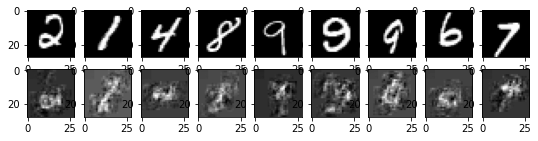

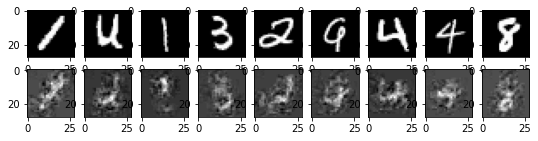

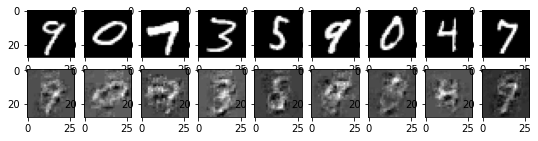

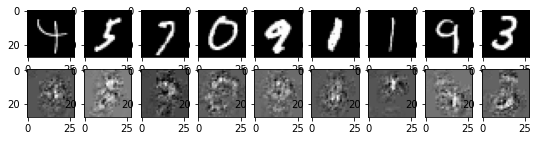

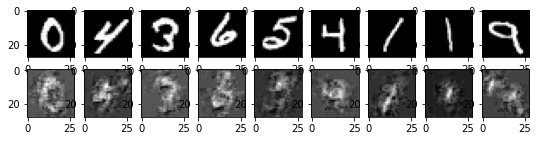

In [107]:
#Plotting the images for convolutional Autoencoder

for k in range(0, num_epochs, 1):
    plt.figure(figsize = (9,2))
    plt.gray()
    
    #because it is a Tensor, so we want to detach and then convert into a numpy array
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i + 1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9 :
            break
        plt.subplot(2, 9, 9 + i + 1)
        plt.imshow(item[0])

In [102]:
img, label = next(dataiter)

In [103]:
recon = model.reconstruct(img)
model.plot(recon)

AttributeError: module 'torch.nn' has no attribute 'relu'

torch.Size([9, 10, 2, 2])
Drop
torch.Size([9, 10, 4])
torch.Size([9, 10])
Drop
tensor([[0.9271, 0.9949, 0.9910, 0.9986, 0.9567, 0.9874, 0.9619, 0.9792, 0.8730,
         0.9510],
        [0.8988, 0.9894, 0.9829, 0.9849, 0.9510, 0.9799, 0.9515, 0.9652, 0.8381,
         0.9502]])


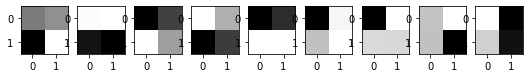

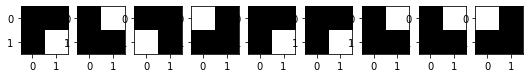

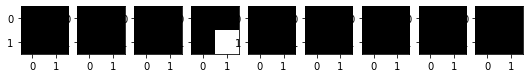

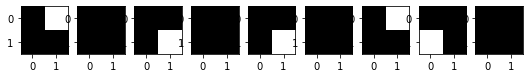

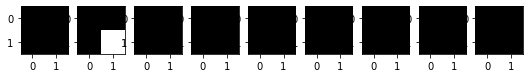

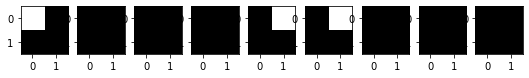

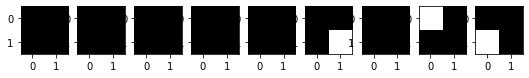

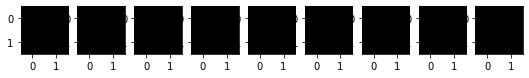

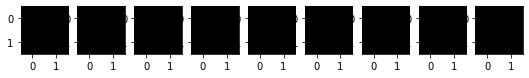

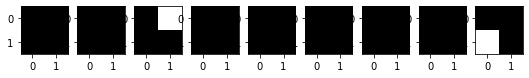

In [89]:
torch.manual_seed(10)
k_percent = 0.3
hiddenMaps = torch.rand(9, 10, 2, 2)
spatial = img.clone()
lifetime = img.clone()
print(hiddenMaps.shape)
shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 26, 26])
n_batches = shape[0]
n_features = shape[1]
size = shape[2]
k = math.floor(n_batches * k_percent)

# COnv Layers
# self.conv1      = nn.Conv2d(1, 15, 5, stride=1, padding = 2)  # size:N, 28, 28
# self.conv2      = nn.Conv2d(1, 20, 5, stride=1, padding = 2)  # size:N, 28, 28
# self.transConv1 = nn.ConvTranspose2d(in_channels=20, out_channels=1, kernel_size=11, stride =1, padding = 5) # padding will decrease output size # size:N, 28, 28

def plotting(samples, j = -1):
    sample = samples.detach()
    if j == -1:
        print("Drop")
        plt.figure(figsize = (9,2))
        plt.gray()
        for i, item in enumerate(sample):
            if i >= 9:
                break
            plt.subplot(2, 9, i + 1)
            plt.imshow(item[0])
        
    else:
        plt.figure(figsize = (9,2))
        plt.gray()
        for k, item1 in enumerate(sample[j]):
            if k >= 9:
                break
            plt.subplot(2, 9, k + 1)
            plt.imshow(item1 )

plotting(hiddenMaps)
# Spatial Sparsity
# Step 1: flatten it out, find max_vals

flatten = hiddenMaps.view(n_batches, n_features, -1)
maxval, _ = torch.max(flatten, 2) # max_val return size[n_batches, n_features]
print(flatten.shape)
print(maxval.shape)
# Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
maxval_p = torch.reshape(maxval, (n_batches, n_features, 1, 1))
drop = torch.where(hiddenMaps < maxval_p, 
                   torch.zeros((n_batches, n_features, size, size)), 
                   torch.ones((n_batches,n_features, size, size)))
plotting(drop)
spatial.data = hiddenMaps.data*drop.data



# lifetime Sparsity
top_k, _ = torch.topk(maxval, k, 0) 
print(top_k)
# Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
drop = torch.where(maxval < top_k[k-1:k, :],  
                   torch.zeros((n_batches, n_features)), 
                   torch.ones((n_batches, n_features)))

# To retain the graph, use .data to only modify the data of the tensor
lifetime.data = spatial.data * drop.reshape(n_batches, n_features, 1, 1).data

for i in range(8):
    plotting(lifetime, i)